In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.001, n_iterations=2000):
        self.coefficients = None  # Store model coefficients (intercept + slopes)
        self.MSE = None  # Store Mean Squared Error
        self.r_squared = None  # Store R-squared
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []  # To track loss during training
        
        # Statistical properties
        self.df_error = None
        self.df_regression = None
        self.SSE = None
        self.SSR = None
        self.SST = None
        self.F_stat = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X = X
        self.y = y

        n_samples, n_features = X.shape
        X_b = np.hstack([np.ones((n_samples, 1)), X])  # Add column of 1s

        # Initialize coefficients (including intercept)
        self.coefficients = np.zeros(X_b.shape[1])

        # Gradient Descent
        for _ in range(self.n_iterations):
            y_pred = X_b @ self.coefficients
            residuals = y - y_pred

            gradient = -2 * X_b.T @ residuals / n_samples
            self.coefficients -= self.learning_rate * gradient

            self.loss_history.append(np.mean(residuals**2))

        # Calculate final predictions and metrics
        y_pred = X_b @ self.coefficients
        residuals = y - y_pred

        self.SSE = np.sum(residuals**2)
        self.MSE = self.SSE / (n_samples - n_features - 1)

        y_bar = np.mean(y)
        self.SST = np.sum((y - y_bar)**2)
        self.SSR = np.sum((y_pred - y_bar)**2)

        self.r_squared = self.SSR / self.SST

        self.df_regression = n_features
        self.df_error = n_samples - n_features - 1



    def predict(self, X):
        if self.coefficients is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        X = np.array(X)
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_b @ self.coefficients
    
    def plot(self,X,y):
        if self.coefficients is None:
            raise ValueError("The model has not been fitted yet.")
        
        # Ensure X and y are numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Scatter plot for actual data points
        ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Data points')
        
        # Plotting the regression plane
        x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
        y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
        X1, Y1 = np.meshgrid(x_range, y_range)
        Z1 = self.coefficients[0] + self.coefficients[1] * X1 + self.coefficients[2] * Y1
        ax.plot_surface(X1, Y1, Z1, color='red', alpha=0.5)
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('y')
        ax.set_title('Multiple Linear Regression (3D)')
        plt.show()

    def anova_table(self):
        if self.coefficients is None:
            raise ValueError("The model has not been fitted yet.")
        
        # Degrees of freedom
        self.df_regression = len(self.coefficients) - 1  # Exclude intercept
        self.df_error = len(self.X) - len(self.coefficients)  # Residuals degrees of freedom
        df_total = len(self.X) - 1
        
        # Mean squares
        MSR = self.SSR / self.df_regression
        MSE = self.SSE / self.df_error
        
        # F-statistic
        self.F_stat = MSR / MSE
        
        # Assemble the ANOVA table
        anova_data = {
            'Source': ['Regression', 'Error', 'Total'],
            'Sum of Squares': [self.SSR, self.SSE, self.SST],
            'Degrees of Freedom': [self.df_regression, self.df_error, df_total],
            'Mean Square': [MSR, MSE, ""],
            'F-Statistic': [self.F_stat, "", ""]
        }
        
        return pd.DataFrame(anova_data)
    
    def hypothesis_test(self, alpha=0.05):
        """
        Perform a hypothesis test based on the F-statistic.
        
        alpha : float
            The significance level for the test.
        
        Prints the hypothesis test result.
        """
        # Critical value for the given significance level
        F_c = stats.f.ppf(1 - alpha, self.df_regression, self.df_error)
        
        # Conclusion based on F-statistic
        if self.F_stat > F_c:
            conclusion = "Reject the null hypothesis. There is a relationship between the features and the target."
        else:
            conclusion = "Fail to reject the null hypothesis. No significant relationship."
        
        print(f"F-statistic: {self.F_stat:.3f}")
        print(f"Critical value: {F_c:.3f}")
        print(f"Conclusion: {conclusion}")

    def interval_estimation(self, alpha=0.05, sigma=None):
        """
        Perform interval estimation for the coefficients.
        
        alpha : float
            The significance level for the test.
        sigma : float
            The standard deviation of the residuals (if available).
        
        Returns:
        -------
        intervals : pd.DataFrame
            DataFrame with lower and upper bounds for each coefficient.
        """
        if sigma is None:
            sigma = np.sqrt(self.MSE)
        
        # Calculate the standard errors of the coefficients
        X_b = np.hstack([np.ones((self.X.shape[0], 1)), self.X])
        var_beta = np.linalg.inv(X_b.T @ X_b) * self.MSE
        
        # t-value for confidence interval
        t_val = stats.t.ppf(1 - alpha / 2, self.df_error)
        
        # Confidence intervals for each coefficient
        intervals = []
        for i, coef in enumerate(self.coefficients):
            se = np.sqrt(var_beta[i, i])
            margin_of_error = t_val * se
            lower_bound = coef - margin_of_error
            upper_bound = coef + margin_of_error
            intervals.append([lower_bound, upper_bound])
        
        return pd.DataFrame(intervals, columns=['Lower Bound', 'Upper Bound'], index=['Intercept'] + [f'X{i}' for i in range(1, self.X.shape[1] + 1)])


In [3]:
df = pd.read_csv("D:/FCDS/Regression Analysis/Sections/DataSets/Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [5]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [6]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

In [7]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [8]:
# Split the data into features (X) and target (y)
X = df[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
y = df['Performance Index']

In [9]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
model = MultipleLinearRegression(learning_rate=0.001, n_iterations=10000) 
model.fit(X_train, y_train)

In [13]:
print(f"Model Coefficients (intercept + slopes): {model.coefficients}")

Model Coefficients (intercept + slopes): [55.31149989  7.40134077 17.63727123  0.30429076  0.81003107  0.54884173]


In [14]:
y_pred = model.predict(X_test)
print(f"Predicted values: {y_pred}")

Predicted values: [54.71185379 22.61551293 47.90314462 ... 16.79341953 63.34327356
 45.94262292]


In [15]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)

      Actual  Predicted
0       51.0  54.711854
1       20.0  22.615513
2       46.0  47.903145
3       28.0  31.289767
4       41.0  43.004570
...      ...        ...
1995    45.0  46.886280
1996    66.0  62.698025
1997    16.0  16.793420
1998    65.0  63.343274
1999    47.0  45.942623

[2000 rows x 2 columns]


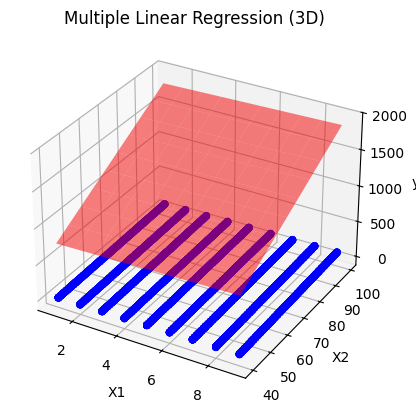

In [16]:
model.plot(X, y)

In [17]:
anova_table = model.anova_table()
print(anova_table)

       Source  Sum of Squares  Degrees of Freedom    Mean Square  \
0  Regression    2.916026e+06                   5  583205.168202   
1       Error    3.335789e+04                7994       4.172865   
2       Total    2.949384e+06                7999                  

     F-Statistic  
0  139761.314711  
1                 
2                 


In [18]:
model.hypothesis_test(alpha=0.05)

F-statistic: 139761.315
Critical value: 2.215
Conclusion: Reject the null hypothesis. There is a relationship between the features and the target.


In [19]:
intervals = model.interval_estimation(alpha=0.05)
print("Confidence Intervals for Coefficients:")
print(intervals)

Confidence Intervals for Coefficients:
           Lower Bound  Upper Bound
Intercept    55.266730    55.356270
X1            7.356562     7.446119
X2           17.592496    17.682047
X3            0.259511     0.349070
X4            0.765251     0.854811
X5            0.504065     0.593619
